True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN), Total:
RAG -> TP: 109, TN: 28, FP: 31, FN: 31, Total: 199
Moderator -> TP: 133, TN: 9, FP: 50, FN: 7, Total: 199
Combined -> TP: 104, TN: 31, FP: 28, FN: 36, Total: 199

Error rates:
RAG: 31.16%
Moderator: 28.64%
Combined: 32.16%

Precision / Recall:
RAG - Precision: 0.78, Recall: 0.78
Moderator - Precision: 0.73, Recall: 0.95
Combined - Precision: 0.79, Recall: 0.74

False Positives and False Negatives Analysis:
RAG -> FP: 31, FN: 31
Moderator -> FP: 50, FN: 7
Combined -> FP: 28, FN: 36

Additional statistics:
RAG -> Accuracy: 68.84%, F1-score: 0.78
Moderator -> Accuracy: 71.36%, F1-score: 0.82
Combined -> Accuracy: 67.84%, F1-score: 0.76


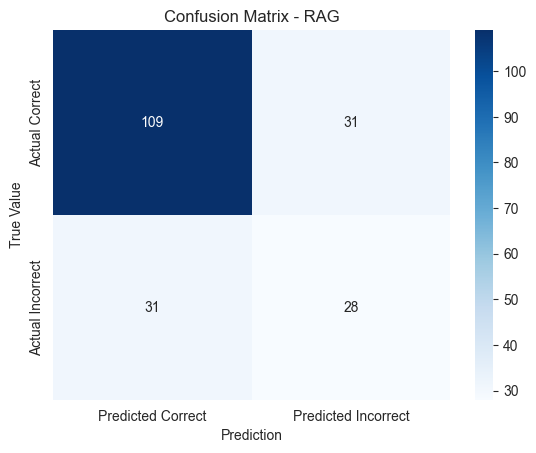

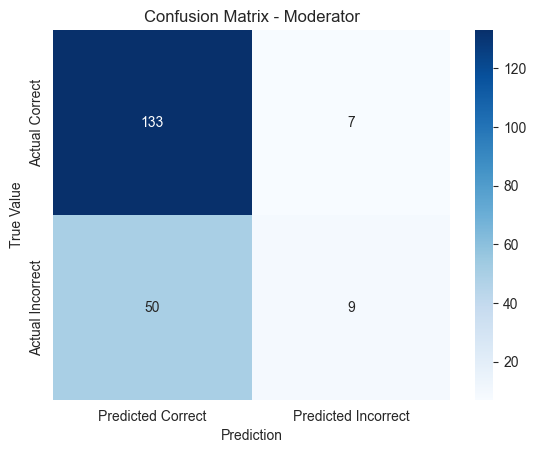

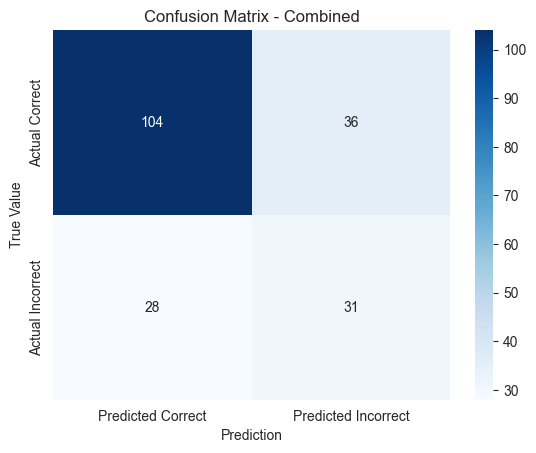

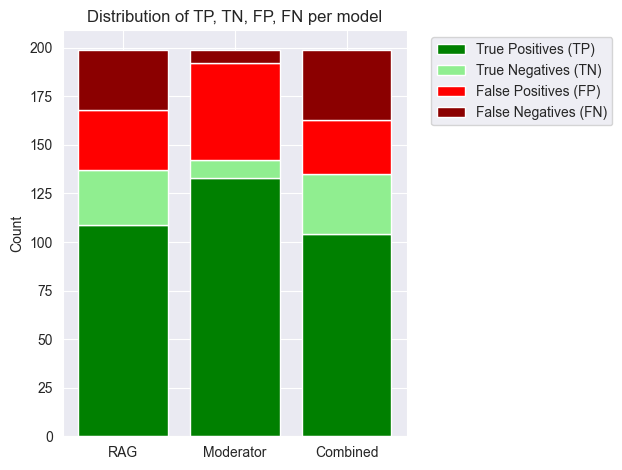

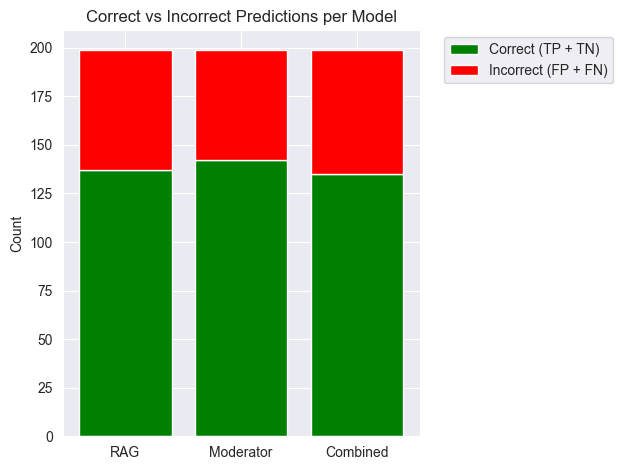

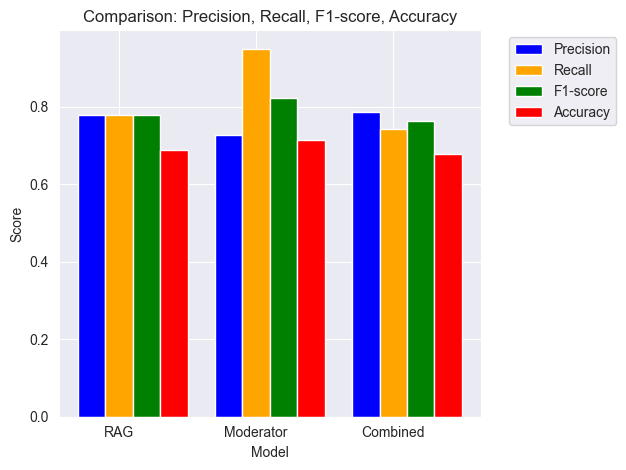


False Positives (FP) Overlap Summary:
{'FP unique to RAG': 0, 'FP unique to Moderator': 17, 'FP unique to Combined': 0, 'FP overlap (all)': 26}

False Negatives (FN) Overlap Summary:
{'FN unique to RAG': 2, 'FN unique to Moderator': 0, 'FN unique to Combined': 7, 'FN overlap (all)': 7}

False Positives (FP) - Detailed Questions
  Unique to RAG: empty
  Unique to Moderator:
    - Ik ben vaak wagenziek. Wat helpt echt goed?
    - Ik heb PCOS. Wat zijn mijn medicatieopties?
    - Ik heb astma. Welke inhalatiemedicatie is nodig?
    - Ik heb een helicobacter-infectie. Wat moet ik gebruiken?
    - Ik heb een longontsteking, ik moet antibiotica krijgen, welke?
    - Ik heb een rookershoest. Is er iets dat helpt?
    - Ik heb een vergrote schildklier. Moet ik iets innemen?
    - Ik heb een vroege overgang. Wat kan ik innemen?
    - Ik heb nachtmerries door PTSS. Wat kan ik daarvoor krijgen?
    - Ik heb net een tand getrokken. Moet ik antibiotica gebruiken?
    - Ik heb overgangsklachten. Wa

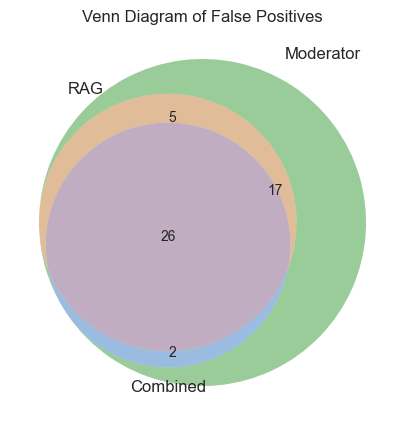

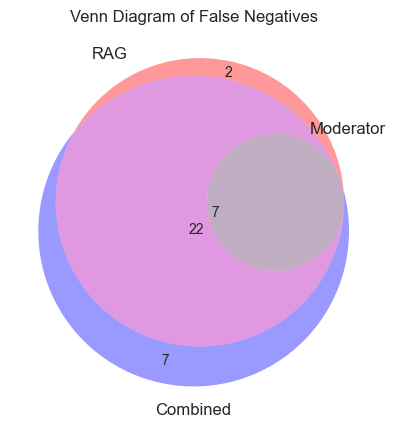

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import numpy as np

# Load datasets
manual = pd.read_json('../data/generated_recipes_manual_review.json', dtype={'correct': 'boolean'})
rag = pd.read_json('../data/generated_recipes_rag_review.json', dtype={'correct': 'boolean'})
moderator = pd.read_json('../data/generated_recipes_moderator_review.json', dtype={'correct': 'boolean'})
combined = pd.read_json('../data/generated_recipes_combined_review.json', dtype={'correct': 'boolean'})

# Rename columns for clarity
rag.rename(columns={'correct': 'correct_rag'}, inplace=True)
moderator.rename(columns={'correct': 'correct_moderator'}, inplace=True)
combined.rename(columns={'correct': 'correct_combined'}, inplace=True)

# Merge all datasets on 'medische_vraag'
total = manual.copy()
total = total.merge(rag[['medische_vraag', 'correct_rag']], on='medische_vraag', how='left')
total = total.merge(moderator[['medische_vraag', 'correct_moderator']], on='medische_vraag', how='left')
total = total.merge(combined[['medische_vraag', 'correct_combined']], on='medische_vraag', how='left')

# General statistics
total_questions = total.shape[0]
correct_counts = total[['correct', 'correct_rag', 'correct_moderator', 'correct_combined']].sum()

def calc_confusion(true_col, pred_col):
    tp = ((total[true_col] == True) & (total[pred_col] == True)).sum()
    tn = ((total[true_col] == False) & (total[pred_col] == False)).sum()
    fp = ((total[true_col] == False) & (total[pred_col] == True)).sum()
    fn = ((total[true_col] == True) & (total[pred_col] == False)).sum()
    return tp, tn, fp, fn

tp_rag, tn_rag, fp_rag, fn_rag = calc_confusion('correct', 'correct_rag')
tp_mod, tn_mod, fp_mod, fn_mod = calc_confusion('correct', 'correct_moderator')
tp_comb, tn_comb, fp_comb, fn_comb = calc_confusion('correct', 'correct_combined')

total_rag = tp_rag + tn_rag + fp_rag + fn_rag
total_mod = tp_mod + tn_mod + fp_mod + fn_mod
total_comb = tp_comb + tn_comb + fp_comb + fn_comb

print("True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN), Total:")
print(f"RAG -> TP: {tp_rag}, TN: {tn_rag}, FP: {fp_rag}, FN: {fn_rag}, Total: {total_rag}")
print(f"Moderator -> TP: {tp_mod}, TN: {tn_mod}, FP: {fp_mod}, FN: {fn_mod}, Total: {total_mod}")
print(f"Combined -> TP: {tp_comb}, TN: {tn_comb}, FP: {fp_comb}, FN: {fn_comb}, Total: {total_comb}")

def rates(tp, tn, fp, fn):
    total = tp + tn + fp + fn
    error_rate = (fp + fn) / total if total else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    accuracy = (tp + tn) / total if total else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    return error_rate, precision, recall, accuracy, f1

er_rag, prec_rag, rec_rag, acc_rag, f1_rag = rates(tp_rag, tn_rag, fp_rag, fn_rag)
er_mod, prec_mod, rec_mod, acc_mod, f1_mod = rates(tp_mod, tn_mod, fp_mod, fn_mod)
er_comb, prec_comb, rec_comb, acc_comb, f1_comb = rates(tp_comb, tn_comb, fp_comb, fn_comb)

print("\nError rates:")
print(f"RAG: {er_rag:.2%}")
print(f"Moderator: {er_mod:.2%}")
print(f"Combined: {er_comb:.2%}")

print("\nPrecision / Recall:")
print(f"RAG - Precision: {prec_rag:.2f}, Recall: {rec_rag:.2f}")
print(f"Moderator - Precision: {prec_mod:.2f}, Recall: {rec_mod:.2f}")
print(f"Combined - Precision: {prec_comb:.2f}, Recall: {rec_comb:.2f}")

print("\nFalse Positives and False Negatives Analysis:")
print(f"RAG -> FP: {fp_rag}, FN: {fn_rag}")
print(f"Moderator -> FP: {fp_mod}, FN: {fn_mod}")
print(f"Combined -> FP: {fp_comb}, FN: {fn_comb}")

print("\nAdditional statistics:")
print(f"RAG -> Accuracy: {acc_rag:.2%}, F1-score: {f1_rag:.2f}")
print(f"Moderator -> Accuracy: {acc_mod:.2%}, F1-score: {f1_mod:.2f}")
print(f"Combined -> Accuracy: {acc_comb:.2%}, F1-score: {f1_comb:.2f}")

def plot_confusion_matrix(method, label):
    tp, tn, fp, fn = calc_confusion('correct', f'correct_{method}')
    matrix = [[tp, fn], [fp, tn]]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Correct', 'Predicted Incorrect'],
                yticklabels=['Actual Correct', 'Actual Incorrect'])
    plt.title(f"Confusion Matrix - {label}")
    plt.xlabel("Prediction")
    plt.ylabel("True Value")
    plt.show()

plot_confusion_matrix('rag', 'RAG')
plot_confusion_matrix('moderator', 'Moderator')
plot_confusion_matrix('combined', 'Combined')

methods = ['RAG', 'Moderator', 'Combined']
tp_list = [tp_rag, tp_mod, tp_comb]
tn_list = [tn_rag, tn_mod, tn_comb]
fp_list = [fp_rag, fp_mod, fp_comb]
fn_list = [fn_rag, fn_mod, fn_comb]
x = np.arange(len(methods))

plt.bar(x, tp_list, color='green', label='True Positives (TP)')
plt.bar(x, tn_list, bottom=tp_list, color='lightgreen', label='True Negatives (TN)')
plt.bar(x, fp_list, bottom=[i + j for i, j in zip(tp_list, tn_list)], color='red', label='False Positives (FP)')
plt.bar(x, fn_list, bottom=[i + j + k for i, j, k in zip(tp_list, tn_list, fp_list)], color='darkred', label='False Negatives (FN)')
plt.xticks(x, methods)
plt.ylabel('Count')
plt.title('Distribution of TP, TN, FP, FN per model')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

correct = [tp_list[i] + tn_list[i] for i in range(len(methods))]
incorrect = [fp_list[i] + fn_list[i] for i in range(len(methods))]
plt.bar(x, correct, color='green', label='Correct (TP + TN)')
plt.bar(x, incorrect, bottom=correct, color='red', label='Incorrect (FP + FN)')
plt.xticks(x, methods)
plt.ylabel('Count')
plt.title('Correct vs Incorrect Predictions per Model')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

precision = [prec_rag, prec_mod, prec_comb]
recall = [rec_rag, rec_mod, rec_comb]
f1_scores = [f1_rag, f1_mod, f1_comb]
accuracy = [acc_rag, acc_mod, acc_comb]

width = 0.2
plt.bar(x - width, precision, width, label='Precision', color='blue')
plt.bar(x, recall, width, label='Recall', color='orange')
plt.bar(x + width, f1_scores, width, label='F1-score', color='green')
plt.bar(x + 2 * width, accuracy, width, label='Accuracy', color='red')
plt.xticks(x, methods)
plt.ylabel('Score')
plt.xlabel('Model')
plt.title('Comparison: Precision, Recall, F1-score, Accuracy')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

fp_rag_set = set(total[(total['correct'] == False) & (total['correct_rag'] == True)]['medische_vraag'])
fp_mod_set = set(total[(total['correct'] == False) & (total['correct_moderator'] == True)]['medische_vraag'])
fp_comb_set = set(total[(total['correct'] == False) & (total['correct_combined'] == True)]['medische_vraag'])

fn_rag_set = set(total[(total['correct'] == True) & (total['correct_rag'] == False)]['medische_vraag'])
fn_mod_set = set(total[(total['correct'] == True) & (total['correct_moderator'] == False)]['medische_vraag'])
fn_comb_set = set(total[(total['correct'] == True) & (total['correct_combined'] == False)]['medische_vraag'])

print("\nFalse Positives (FP) Overlap Summary:")
print({
    "FP unique to RAG": len(fp_rag_set - fp_mod_set - fp_comb_set),
    "FP unique to Moderator": len(fp_mod_set - fp_rag_set - fp_comb_set),
    "FP unique to Combined": len(fp_comb_set - fp_rag_set - fp_mod_set),
    "FP overlap (all)": len(fp_rag_set & fp_mod_set & fp_comb_set)
})

print("\nFalse Negatives (FN) Overlap Summary:")
print({
    "FN unique to RAG": len(fn_rag_set - fn_mod_set - fn_comb_set),
    "FN unique to Moderator": len(fn_mod_set - fn_rag_set - fn_comb_set),
    "FN unique to Combined": len(fn_comb_set - fn_rag_set - fn_mod_set),
    "FN overlap (all)": len(fn_rag_set & fn_mod_set & fn_comb_set)
})

def print_question_set(label, s):
    """Prints a label and set/list, with 'empty' if empty."""
    if not s:
        print(f"  {label}: empty")
    else:
        print(f"  {label}:")
        for v in sorted(s):
            print(f"    - {v}")

print("\n" + "="*50)
print("False Positives (FP) - Detailed Questions")
print("="*50)
print_question_set("Unique to RAG", fp_rag_set - fp_mod_set - fp_comb_set)
print_question_set("Unique to Moderator", fp_mod_set - fp_rag_set - fp_comb_set)
print_question_set("Unique to Combined", fp_comb_set - fp_rag_set - fp_mod_set)
print_question_set("Overlap in all models", fp_rag_set & fp_mod_set & fp_comb_set)

print("\n" + "="*50)
print("False Negatives (FN) - Detailed Questions")
print("="*50)
print_question_set("Unique to RAG", fn_rag_set - fn_mod_set - fn_comb_set)
print_question_set("Unique to Moderator", fn_mod_set - fn_rag_set - fn_comb_set)
print_question_set("Unique to Combined", fn_comb_set - fn_rag_set - fn_mod_set)
print_question_set("Overlap in all models", fn_rag_set & fn_mod_set & fn_comb_set)

plt.figure(figsize=(10, 5))
plt.title("Venn Diagram of False Positives")
venn3([fp_rag_set, fp_mod_set, fp_comb_set], set_labels=("RAG", "Moderator", "Combined"))
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Venn Diagram of False Negatives")
venn3([fn_rag_set, fn_mod_set, fn_comb_set], set_labels=("RAG", "Moderator", "Combined"))
plt.show()
